In [ ]:
# Import the drive module from google.colab
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install vaderSentiment
!pip install nrclex
!pip install pyLDAvis
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=c5c1bb5fc632a023e3cdae77ceb14b383f14252ba5190ee060856d0ed8f75842
  Stored in directory: /root/.cache/pip/wheels/d2/10/44/6abfb1234298806a145fd6bcaec8cbc712e88dd1cd6cb242fa
Successfully built nrclex
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
import nltk
from nltk import bigrams, trigrams
from nltk.corpus import stopwords
from collections import Counter
from gensim import corpora
import gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
import re

In [ ]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Unwanted terms
unwanted_terms = {'fha','fha home', 'fha washington', 'home loans', 'virginia fha', 'florida fha', 'wisconsin fha', 'de la', 'west virginia', 'home', 'loans',
                  'said', 'de', 'wisconsin home', 'washington home', 'virginia', 'west', 'florida', 'washington', 'u', 'U', 'la', 'wisconsin', 'wyoming'}

# Function to preprocess the text and remove unwanted terms
def preprocess_text(text):
    # Removing punctuation and lowercasing
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text) if word.isalpha() and word not in stopwords.words('english') and word not in unwanted_terms]
    return tokens

# Reading the CSV file
df = pd.read_csv('/content/drive/My Drive/Conflict_data/GDELT/middle_east_scraped_articles_clean.csv')

# Apply preprocessing
processed_docs = df['Content'].map(preprocess_text)

# Function to join tokens back into a string for sentiment analysis
def join_tokens(tokens):
    return ' '.join(tokens)

df['processed_content'] = processed_docs.map(join_tokens)

# Define a function for TextBlob sentiment analysis
def textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Define a function for VADER sentiment analysis
def vader_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(text)
    return vs['compound']

# Apply TextBlob sentiment analysis
df['textblob_polarity'] = df['processed_content'].apply(textblob_sentiment)

# Apply VADER sentiment analysis
df['vader_compound'] = df['processed_content'].apply(vader_sentiment)

# Assign sentiment based on VADER compound score
df['sentiment'] = np.where(df['vader_compound'] >= 0.05, 'positive', 'negative')

# Assign sentiment type based on TextBlob polarity
df['textblob_sentiment_type'] = ''
df.loc[df.textblob_polarity > 0, 'textblob_sentiment_type'] = 'POSITIVE'
df.loc[df.textblob_polarity == 0, 'textblob_sentiment_type'] = 'NEUTRAL'
df.loc[df.textblob_polarity < 0, 'textblob_sentiment_type'] = 'NEGATIVE'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-5-8183d8bdb86f>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  graph = sns.countplot(y='emotion', data=df, palette='flare', order=emotion_order)


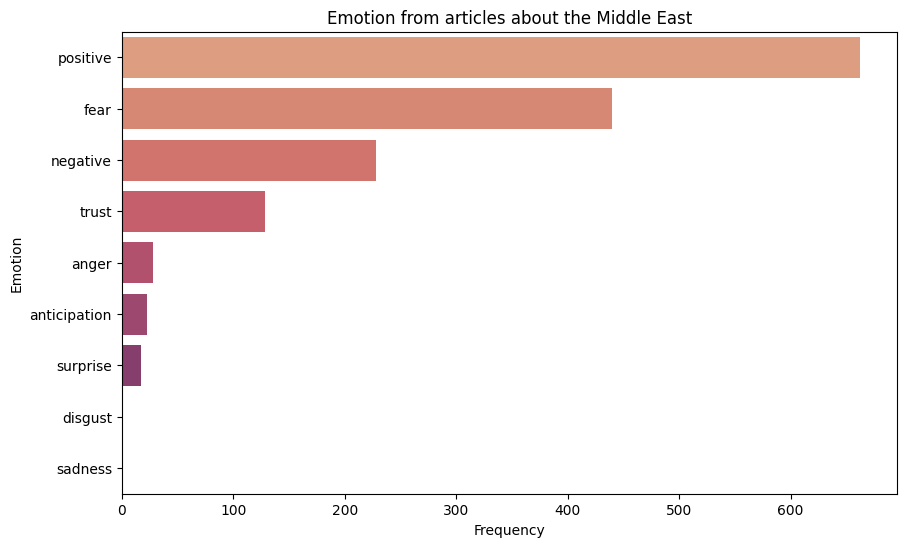

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nrclex import NRCLex

# Emotion Detection using NRCLex
df['emotion'] = df['processed_content'].apply(lambda x: NRCLex(x).top_emotions[0][0] if NRCLex(x).top_emotions else 'none')

# Reorder the 'emotion' column based on the count
emotion_order = df['emotion'].value_counts().index
df['emotion'] = pd.Categorical(df['emotion'], categories=emotion_order, ordered=True)

# Plotting the emotion distribution in descending order
plt.figure(figsize=(10, 6))
graph = sns.countplot(y='emotion', data=df, palette='flare', order=emotion_order)
graph.set(xlabel='Frequency', ylabel='Emotion', title='Emotion from articles about the Middle East')
plt.show()

## Collacation/Bigram Analysis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    [sudan tribune, tribune plural, plural news, n...
1    [blast went, went central, central residential...
2    [jack doyle, doyle daily, daily mail, mail pub...
3    [jack doyle, doyle daily, daily mail, mail pub...
4    [wasnt deadliest, deadliest year, year syria, ...
Name: Bigrams, dtype: object


<ipython-input-8-3ea4e4954550>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(bigram_labels), y=list(counts), palette='plasma')


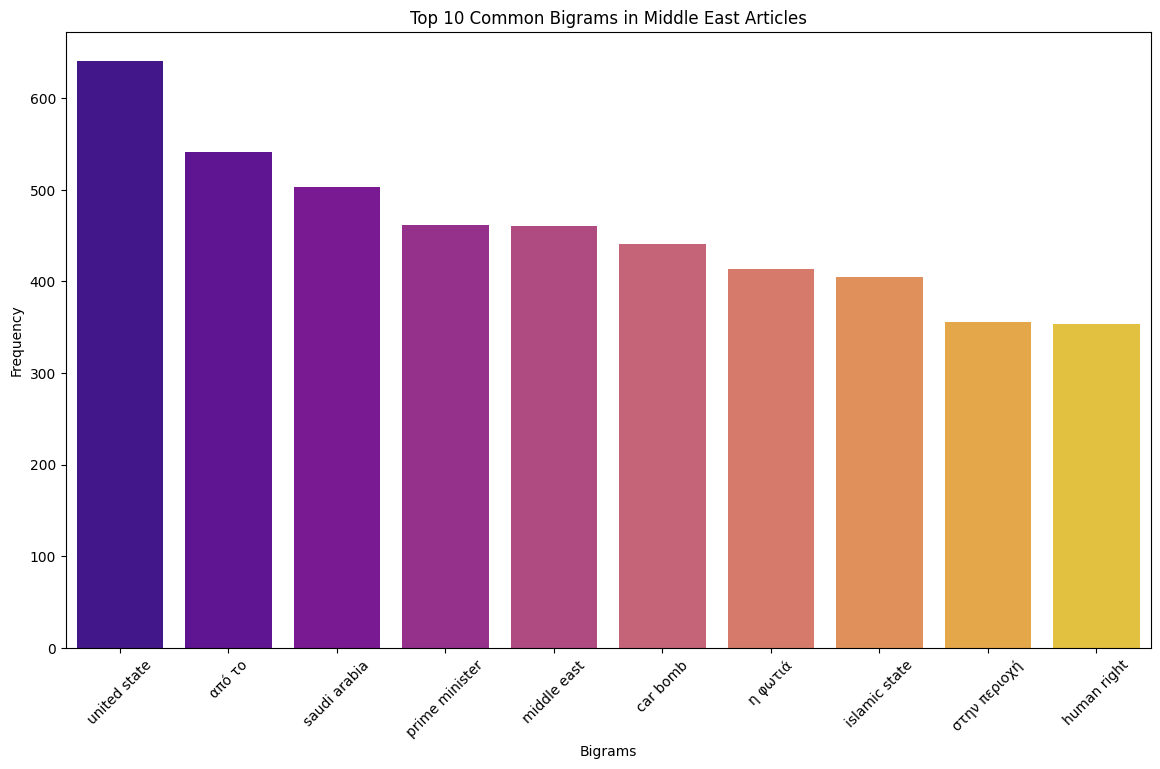

In [ ]:
# Function to generate n-grams
def generate_ngrams(text, n=2):
    words = [word for word in nltk.word_tokenize(text.lower()) if word.isalpha() and word not in stopwords.words('english') and word not in unwanted_terms]
    n_grams = bigrams(words) if n == 2 else trigrams(words)
    return [' '.join(grams) for grams in n_grams]

# Applying bigrams analysis (you can change to trigrams by setting n=3)
df['Bigrams'] = df['processed_content'].apply(lambda x: generate_ngrams(x, n=2))

# Displaying some bigrams
print(df['Bigrams'].head())

# Aggregating all bigrams in the dataset
all_bigrams = sum(df['Bigrams'].tolist(), [])

# Counting the frequency of each bigram
bigram_counts = Counter(all_bigrams).most_common(10)

# Preparing data for plotting
bigram_labels, counts = zip(*bigram_counts)

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(x=list(bigram_labels), y=list(counts), palette='plasma')
plt.title('Top 10 Common Bigrams in Middle East Articles')
plt.ylabel('Frequency')
plt.xlabel('Bigrams')
plt.xticks(rotation=45)
plt.show()

## Collacation/Trigram Analysis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sample Trigrams:
0    [sudan tribune plural, tribune plural news, pl...
1    [blast went central, went central residential,...
2    [jack doyle daily, doyle daily mail, daily mai...
3    [jack doyle daily, doyle daily mail, daily mai...
4    [wasnt deadliest year, deadliest year syria, y...
Name: Trigrams, dtype: object


<ipython-input-6-b54bea6d0ad4>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(trigram_labels), y=list(counts), palette='plasma')


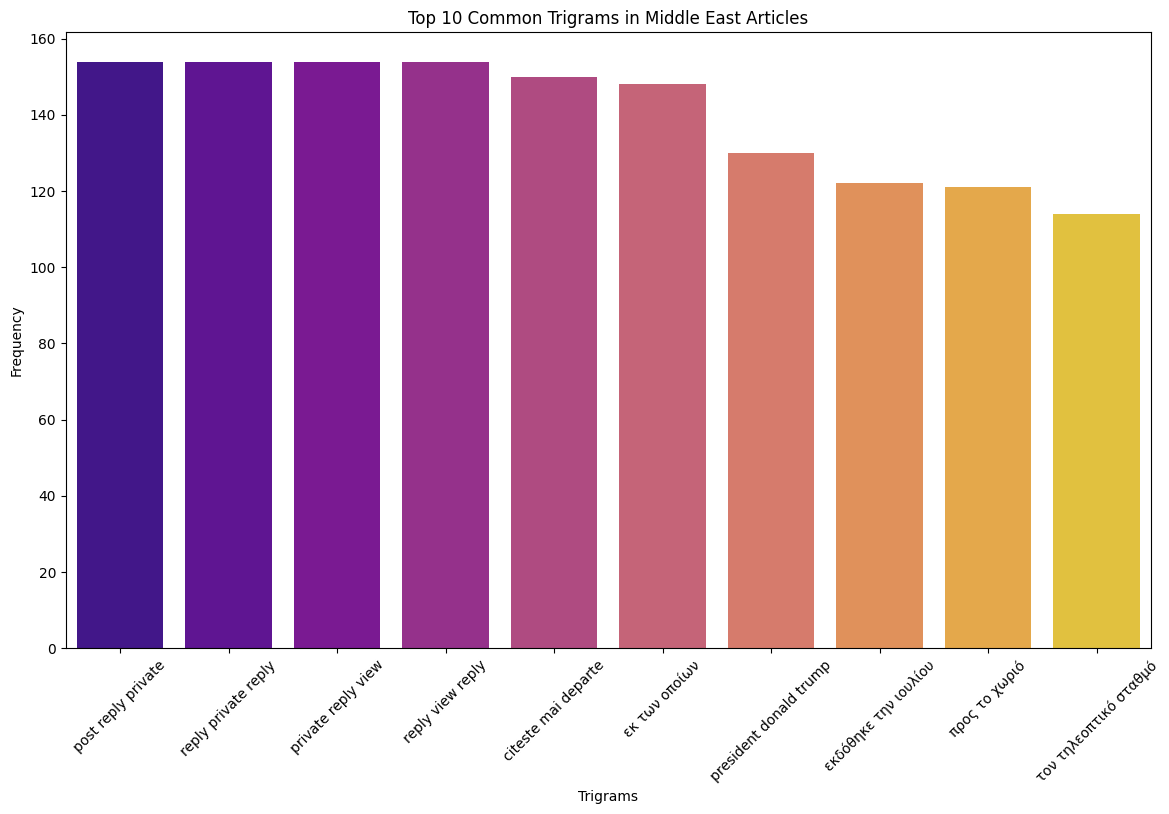

In [ ]:
# Function to generate n-grams
def generate_ngrams(text, n=3):
    words = [word for word in nltk.word_tokenize(text.lower()) if word.isalpha() and word not in stopwords.words('english') and word not in unwanted_terms]
    n_grams = trigrams(words) if n == 3 else bigrams(words)  # Default to trigrams
    return [' '.join(grams) for grams in n_grams]

# Applying trigrams analysis
df['Trigrams'] = df['processed_content'].apply(lambda x: generate_ngrams(x, n=3))

# Displaying some trigrams
print("Sample Trigrams:")
print(df['Trigrams'].head())

# Aggregating all trigrams in the dataset
all_trigrams = sum(df['Trigrams'].tolist(), [])

# Counting the frequency of each trigram
trigram_counts = Counter(all_trigrams).most_common(10)

# Preparing data for plotting
trigram_labels, counts = zip(*trigram_counts)

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(x=list(trigram_labels), y=list(counts), palette='plasma')
plt.title('Top 10 Common Trigrams in Middle East Articles')
plt.ylabel('Frequency')
plt.xlabel('Trigrams')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Create a dictionary and corpus for topic modeling
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Function to compute coherence values for various number of topics
def compute_coherence_values(dictionary, corpus, texts, start, stop, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.022*"في" + 0.015*"من" + 0.011*"क" + 0.010*"على"')
(1, '0.006*"u" + 0.004*"state" + 0.004*"force" + 0.004*"country"')
(2, '0.012*"iran" + 0.007*"u" + 0.006*"israel" + 0.005*"iraq"')
(3, '0.019*"le" + 0.009*"à" + 0.008*"et" + 0.008*"de"')
(4, '0.023*"di" + 0.013*"da" + 0.012*"e" + 0.011*"il"')
(5, '0.020*"en" + 0.020*"el" + 0.017*"que" + 0.011*"los"')
(6, '0.031*"και" + 0.019*"το" + 0.017*"από" + 0.015*"της"')
(7, '0.012*"في" + 0.008*"من" + 0.005*"على" + 0.004*"new"')


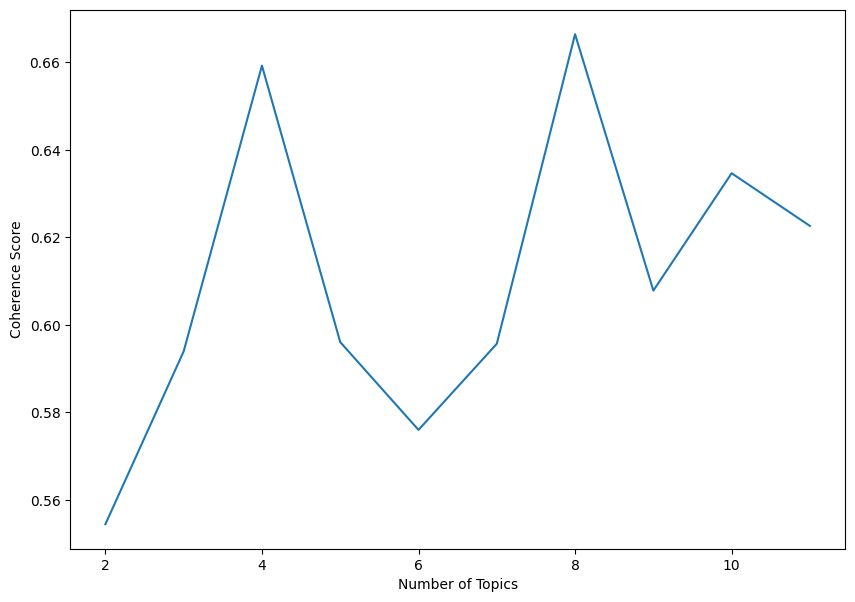

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.315295 -0.083972       1        1  48.773533
6     -0.234639 -0.320068       2        1  14.114477
2      0.240706 -0.050046       3        1   9.697719
0     -0.132876  0.195092       4        1   6.454245
5     -0.050524  0.002735       5        1   5.734733
3     -0.053748  0.070191       6        1   5.676114
4     -0.081947  0.079347       7        1   4.911680
7     -0.002267  0.106721       8        1   4.637498, topic_info=           Term         Freq        Total Category  logprob  loglift
4121        και  4376.000000  4376.000000  Default  30.0000  30.0000
4196         το  2745.000000  2745.000000  Default  29.0000  29.0000
4064        από  2483.000000  2483.000000  Default  28.0000  28.0000
4661         في  1990.000000  1990.000000  Default  27.0000  27.0000
41626       της  2116.000000  2116.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1792   election    96.383533   437.648441   Topic8  -6.1809   1.5579
11420       الى    68.666995   163.207885   Topic8  -6.5199   2.2052
5473      اليوم    59.233434   122.397074   Topic8  -6.6677   2.3452
225        city    65.432695   853.141467   Topic8  -6.5682   0.5031
246    interior    59.645838   192.917039   Topic8  -6.6608   1.8972

[556 rows x 6 columns], token_table=        Topic      Freq     Term
term                            
103025      3  0.972333   abqaiq
6493        5  0.983319  acuerdo
211         1  0.969024   afghan
211         3  0.001030   afghan
211         5  0.018536   afghan
...       ...       ...      ...
13897       4  0.989151        म
13918       4  0.974088       यह
13953       4  0.983775        स
13991       1  0.008208        ह
13991       4  0.989012        ह

[1224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 3, 1, 6, 4, 5, 8])

In [ ]:
# Compute coherence values
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_docs, start=2, stop=12, step=1)

# Determine the optimal number of topics
optimal_index = coherence_values.index(max(coherence_values))
optimal_num_topics = range(2, 12)[optimal_index]
best_ldamodel = model_list[optimal_index]

# Displaying the topics of the optimal model
topics = best_ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

# Plotting coherence scores
plt.figure(figsize=(10,7))
plt.plot(range(2, 12), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

# Visualizing with pyLDAvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_ldamodel, corpus, dictionary)
vis

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Getting main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution, and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]])], ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Adding original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename("Content")], axis=1)
    return sent_topics_df

# Assuming 'df' is your dataframe containing the 'Content' column
df_topic_sents_keywords = format_topics_sentences(ldamodel=best_ldamodel, corpus=corpus, texts=df['Content'])

# Display the resulting dataframe
print(df_topic_sents_keywords.head())

# If you're using Jupyter Notebook, you can use display for a better visual
from IPython.display import display
display(df_topic_sents_keywords.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   Dominant_Topic  Perc_Contribution  \
0               1             0.9980   
1               1             0.9929   
2               1             0.9580   
3               1             0.9580   
4               1             0.9966   

                                      Topic_Keywords  \
0  u, state, force, country, people, year, also, ...   
1  u, state, force, country, people, year, also, ...   
2  u, state, force, country, people, year, also, ...   
3  u, state, force, country, people, year, also, ...   
4  u, state, force, country, people, year, also, ...   

                                             Content  
0  Sudan Tribune Plural news and views on Sudan S...  
1  The blast went off in a central residential ar...  
2  By Jack Doyle for the Daily Mail   Published: ...  
3  By Jack Doyle for the Daily Mail   Published: ...  
4  It wasn't the deadliest year in Syria's ongoin...  


,Dominant_Topic,Perc_Contribution,Topic_Keywords,Content
0,1,0.9980,"u, state, force, country, people, year, also, ...",Sudan Tribune Plural news and views on Sudan S...
1,1,0.9929,"u, state, force, country, people, year, also, ...",The blast went off in a central residential ar...
2,1,0.9580,"u, state, force, country, people, year, also, ...",By Jack Doyle for the Daily Mail Published: ...
3,1,0.9580,"u, state, force, country, people, year, also, ...",By Jack Doyle for the Daily Mail Published: ...
4,1,0.9966,"u, state, force, country, people, year, also, ...",It wasn't the deadliest year in Syria's ongoin...


### 2. Analyzing Document Distribution Across Topics

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenating Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Changing Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3. Counting Tokens by Topic

In [ ]:
# Token count per topic
topic_token_counts = {}
for topic_id, wp in best_ldamodel.show_topics(formatted=False, num_words=500):
    topic_token_counts[topic_id] = sum(count for word, count in wp)

# Calculating percentage of tokens per topic relative to the total number of tokens
total_tokens = sum(topic_token_counts.values())
token_percentages = {topic_id: (count / total_tokens) * 100 for topic_id, count in topic_token_counts.items()}

# Display the results
print(df_dominant_topics)
print(token_percentages)

      Dominant_Topic                                     Topic_Keywords  \
0                  1  u, state, force, country, people, year, also, ...   
1                  1  u, state, force, country, people, year, also, ...   
2                  1  u, state, force, country, people, year, also, ...   
3                  1  u, state, force, country, people, year, also, ...   
4                  1  u, state, force, country, people, year, also, ...   
...              ...                                                ...   
1524               1  u, state, force, country, people, year, also, ...   
1525               0            في, من, क, على, أن, إلى, عن, و, ह, التي   
1526               1  u, state, force, country, people, year, also, ...   
1527               1  u, state, force, country, people, year, also, ...   
1528               6           και, το, από, της, με, в, η, σε, να, στο   

      Num_Documents  Perc_Documents  
0             134.0          0.0876  
1             929.0    

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!pip install vaderSentiment
!pip install nrclex
!pip install pyLDAvis
!pip install gensim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Sample Bigrams:
0    [sudan tribune, tribune plural, plural news, n...
1    [blast went, went central, central residential...
2    [jack doyle, doyle daily, daily mail, mail pub...
3    [jack doyle, doyle daily, daily mail, mail pub...
4    [wasnt deadliest, deadliest year, year syria, ...
Name: Bigrams, dtype: object


<ipython-input-3-aea5a2e51de6>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(bigram_labels), y=list(counts), palette='plasma')


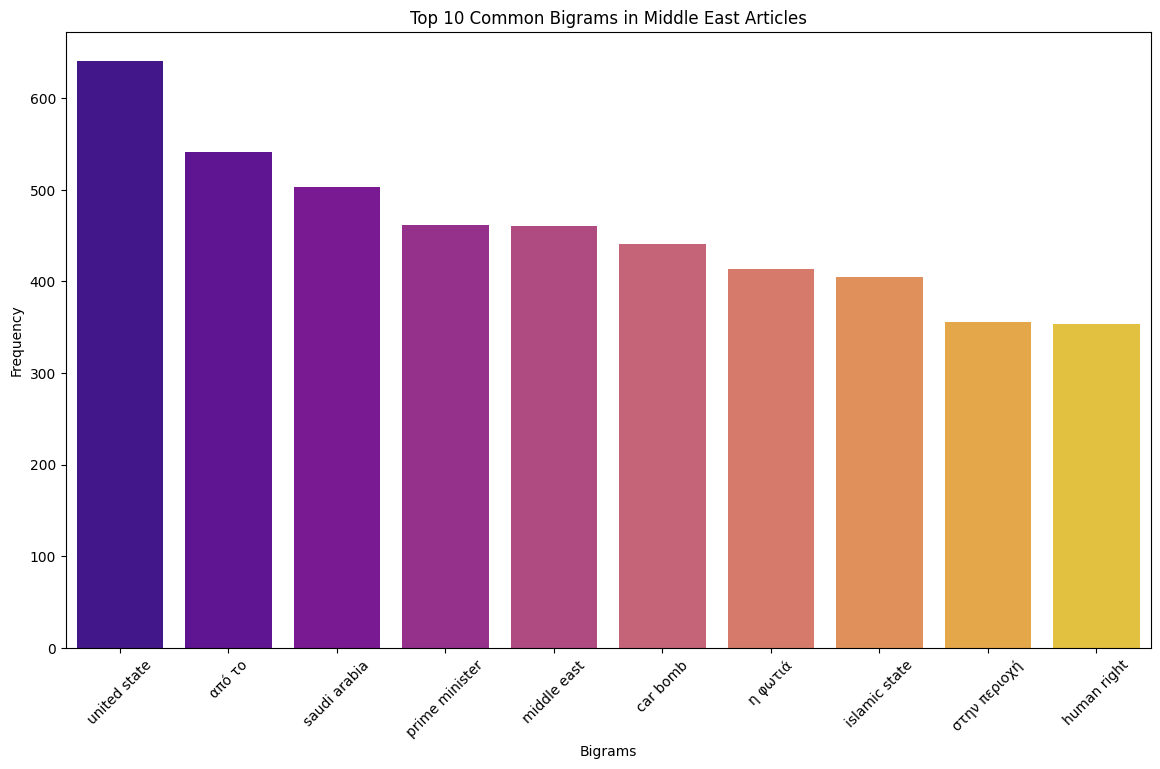


Optimal Number of Topics: 8

Topics in the Optimal Model:
(0, '0.022*"في" + 0.015*"من" + 0.011*"क" + 0.010*"على"')
(1, '0.006*"u" + 0.004*"state" + 0.004*"force" + 0.004*"country"')
(2, '0.012*"iran" + 0.007*"u" + 0.006*"israel" + 0.005*"iraq"')
(3, '0.019*"le" + 0.009*"à" + 0.008*"et" + 0.008*"de"')
(4, '0.023*"di" + 0.013*"da" + 0.012*"e" + 0.011*"il"')
(5, '0.020*"en" + 0.020*"el" + 0.017*"que" + 0.011*"los"')
(6, '0.031*"και" + 0.019*"το" + 0.017*"από" + 0.015*"της"')
(7, '0.012*"في" + 0.008*"من" + 0.005*"على" + 0.004*"new"')


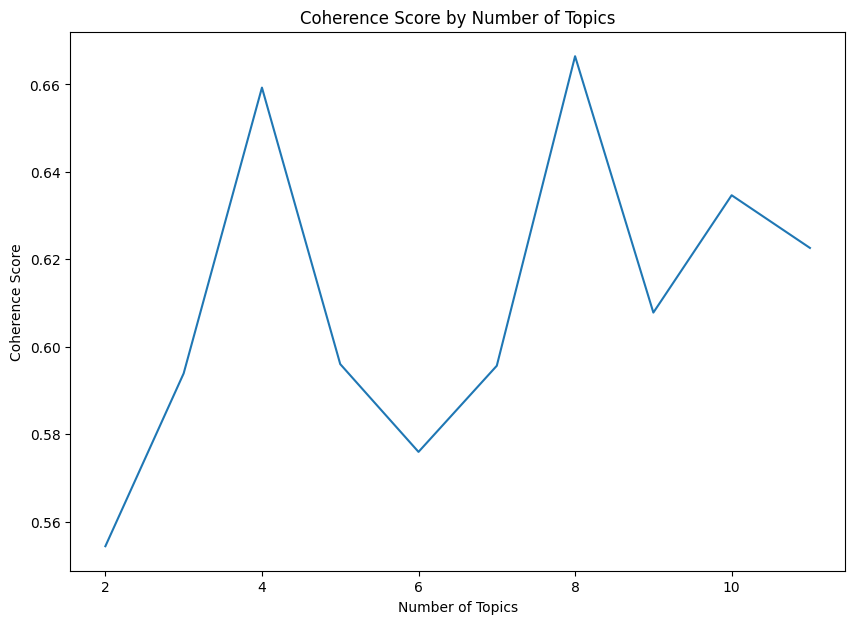


Document Distribution Across Topics:
      Dominant_Topic                                     Topic_Keywords  \
0                  1  u, state, force, country, people, year, also, ...   
1                  1  u, state, force, country, people, year, also, ...   
2                  1  u, state, force, country, people, year, also, ...   
3                  1  u, state, force, country, people, year, also, ...   
4                  1  u, state, force, country, people, year, also, ...   
...              ...                                                ...   
1524               1  u, state, force, country, people, year, also, ...   
1525               0            في, من, क, على, أن, إلى, عن, و, ह, التي   
1526               1  u, state, force, country, people, year, also, ...   
1527               1  u, state, force, country, people, year, also, ...   
1528               6           και, το, από, της, με, в, η, σε, να, στο   

      Num_Documents  Perc_Documents  
0             134.0    

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
from nltk import bigrams, trigrams
from nltk.corpus import stopwords
from collections import Counter
from gensim import corpora
import gensim
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
import re

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Unwanted terms
unwanted_terms = {'fha','fha home', 'fha washington', 'home loans', 'virginia fha', 'florida fha', 'wisconsin fha', 'de la', 'west virginia', 'home', 'loans',
                  'said', 'de', 'wisconsin home', 'washington home', 'virginia', 'west', 'florida', 'washington', 'u', 'U', 'la', 'wisconsin', 'wyoming'}

# Function to preprocess the text and remove unwanted terms
def preprocess_text(text):
    # Removing punctuation and lowercasing
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text) if word.isalpha() and word not in stopwords.words('english') and word not in unwanted_terms]
    return tokens

# Reading the CSV file
df = pd.read_csv('/content/drive/My Drive/Conflict_data/GDELT/middle_east_scraped_articles_clean.csv')

# Apply preprocessing
processed_docs = df['Content'].map(preprocess_text)

# Function to join tokens back into a string for sentiment analysis
def join_tokens(tokens):
    return ' '.join(tokens)

df['processed_content'] = processed_docs.map(join_tokens)

# Define a function for TextBlob sentiment analysis
def textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply TextBlob sentiment analysis
df['textblob_polarity'] = df['processed_content'].apply(textblob_sentiment)

# Assign sentiment type based on TextBlob polarity
df['textblob_sentiment_type'] = ''
df.loc[df.textblob_polarity > 0, 'textblob_sentiment_type'] = 'POSITIVE'
df.loc[df.textblob_polarity == 0, 'textblob_sentiment_type'] = 'NEUTRAL'
df.loc[df.textblob_polarity < 0, 'textblob_sentiment_type'] = 'NEGATIVE'

# Function to generate n-grams
def generate_ngrams(text, n=2):
    words = [word for word in nltk.word_tokenize(text.lower()) if word.isalpha() and word not in stopwords.words('english') and word not in unwanted_terms]
    n_grams = bigrams(words) if n == 2 else trigrams(words)
    return [' '.join(grams) for grams in n_grams]

# Applying bigrams analysis (you can change to trigrams by setting n=3)
df['Bigrams'] = df['processed_content'].apply(lambda x: generate_ngrams(x, n=2))

# Displaying some bigrams
print("Sample Bigrams:")
print(df['Bigrams'].head())

# Aggregating all bigrams in the dataset
all_bigrams = sum(df['Bigrams'].tolist(), [])

# Counting the frequency of each bigram
bigram_counts = Counter(all_bigrams).most_common(10)

# Preparing data for plotting
bigram_labels, counts = zip(*bigram_counts)

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(x=list(bigram_labels), y=list(counts), palette='plasma')
plt.title('Top 10 Common Bigrams in Middle East Articles')
plt.ylabel('Frequency')
plt.xlabel('Bigrams')
plt.xticks(rotation=45)
plt.show()

# Create a dictionary and corpus for topic modeling
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Function to compute coherence values for various number of topics
def compute_coherence_values(dictionary, corpus, texts, start, stop, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Compute coherence values
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_docs, start=2, stop=12, step=1)

# Determine the optimal number of topics
optimal_index = coherence_values.index(max(coherence_values))
optimal_num_topics = range(2, 12)[optimal_index]
best_ldamodel = model_list[optimal_index]

# Displaying the topics of the optimal model
topics = best_ldamodel.print_topics(num_words=4)
print("\nOptimal Number of Topics:", optimal_num_topics)
print("\nTopics in the Optimal Model:")
for topic in topics:
    print(topic)

# Plotting coherence scores
plt.figure(figsize=(10,7))
plt.plot(range(2, 12), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score by Number of Topics")
plt.show()

# Visualizing with pyLDAvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_ldamodel, corpus, dictionary)
vis

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Getting main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution, and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]])], ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Adding original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename("Content")], axis=1)
    return sent_topics_df

# Assuming 'df' is your dataframe containing the 'Content' column
df_topic_sents_keywords = format_topics_sentences(ldamodel=best_ldamodel, corpus=corpus, texts=df['Content'])

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenating Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Changing Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Display the results with explanations
print("\nDocument Distribution Across Topics:")
print(df_dominant_topics)

# Token count per topic
topic_token_counts = {}
for topic_id, wp in best_ldamodel.show_topics(formatted=False, num_words=500):
    topic_token_counts[topic_id] = sum(count for word, count in wp)

# Calculating percentage of tokens per topic relative to the total number of tokens
total_tokens = sum(topic_token_counts.values())
token_percentages = {topic_id: (count / total_tokens) * 100 for topic_id, count in topic_token_counts.items()}

print("\nToken Percentages by Topic:")
for topic_id, percentage in token_percentages.items():
    print(f"Topic {topic_id}: {percentage:.2f}% of total tokens")

### Creating a Cleaned, Scraped Article CSV File with NRCLex Score

---

In [ ]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
import numpy as np

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Unwanted terms
unwanted_terms = {'fha','fha home', 'fha washington', 'home loans', 'virginia fha', 'florida fha', 'wisconsin fha', 'de la', 'west virginia', 'home', 'loans',
                  'said', 'de', 'wisconsin home', 'washington home', 'virginia', 'west', 'florida', 'washington', 'u', 'U', 'la', 'wisconsin', 'wyoming'}

# Function to preprocess the text and remove unwanted terms
def preprocess_text(text):
    # Removing punctuation and lowercasing
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text) if word.isalpha() and word not in stopwords.words('english') and word not in unwanted_terms]
    return tokens

# Reading the CSV file
df = pd.read_csv('/content/drive/My Drive/Conflict_data/GDELT/middle_east_scraped_articles_clean.csv')

# Apply preprocessing
processed_docs = df['Content'].map(preprocess_text)

# Function to join tokens back into a string for sentiment analysis
def join_tokens(tokens):
    return ' '.join(tokens)

df['processed_content'] = processed_docs.map(join_tokens)

# Define a function for TextBlob sentiment analysis
def textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Define a function for VADER sentiment analysis
def vader_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(text)
    return vs['compound']

# Apply TextBlob sentiment analysis
df['textblob_polarity'] = df['processed_content'].apply(textblob_sentiment)

# Apply VADER sentiment analysis
df['vader_compound'] = df['processed_content'].apply(vader_sentiment)

# Assign sentiment based on VADER compound score
df['sentiment'] = np.where(df['vader_compound'] >= 0.05, 'positive', 'negative')

# Assign sentiment type based on TextBlob polarity
df['textblob_sentiment_type'] = ''
df.loc[df.textblob_polarity > 0, 'textblob_sentiment_type'] = 'POSITIVE'
df.loc[df.textblob_polarity == 0, 'textblob_sentiment_type'] = 'NEUTRAL'
df.loc[df.textblob_polarity < 0, 'textblob_sentiment_type'] = 'NEGATIVE'

# Emotion Detection using NRCLex
df['emotion'] = df['processed_content'].apply(lambda x: NRCLex(x).top_emotions[0][0] if NRCLex(x).top_emotions else 'none')

# Save the processed data
df.to_csv('/content/drive/My Drive/Conflict_data/GDELT/middle_east_scraped_articles_clean_score.csv', index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


<ipython-input-5-82b10e0a44e3>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_emotion_count.index, y=country_emotion_count.values, palette='Reds')


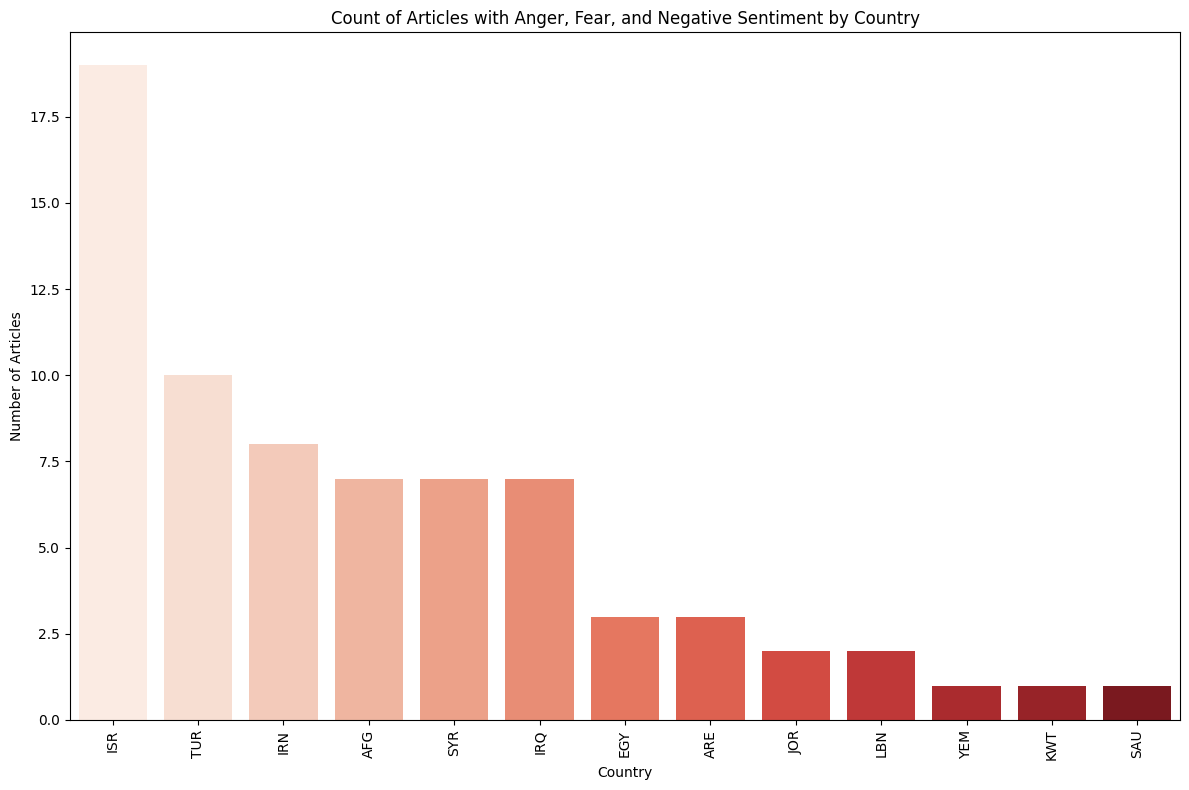

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed data
df = pd.read_csv('/content/drive/My Drive/Conflict_data/GDELT/middle_east_scraped_articles_clean_score.csv')

# Filter for articles with the emotions 'anger' or 'fear' and negative sentiment
filtered_df = df[(df['emotion'].isin(['anger', 'fear'])) & (df['textblob_sentiment_type'] == 'NEGATIVE')]

# Count the number of articles per country with these emotions
country_emotion_count = filtered_df['Actor1CountryCode'].value_counts()

# Plotting the data
plt.figure(figsize=(12, 8))
sns.barplot(x=country_emotion_count.index, y=country_emotion_count.values, palette='Reds')
plt.title('Count of Articles with Anger, Fear, and Negative Sentiment by Country')
plt.xlabel('Country')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

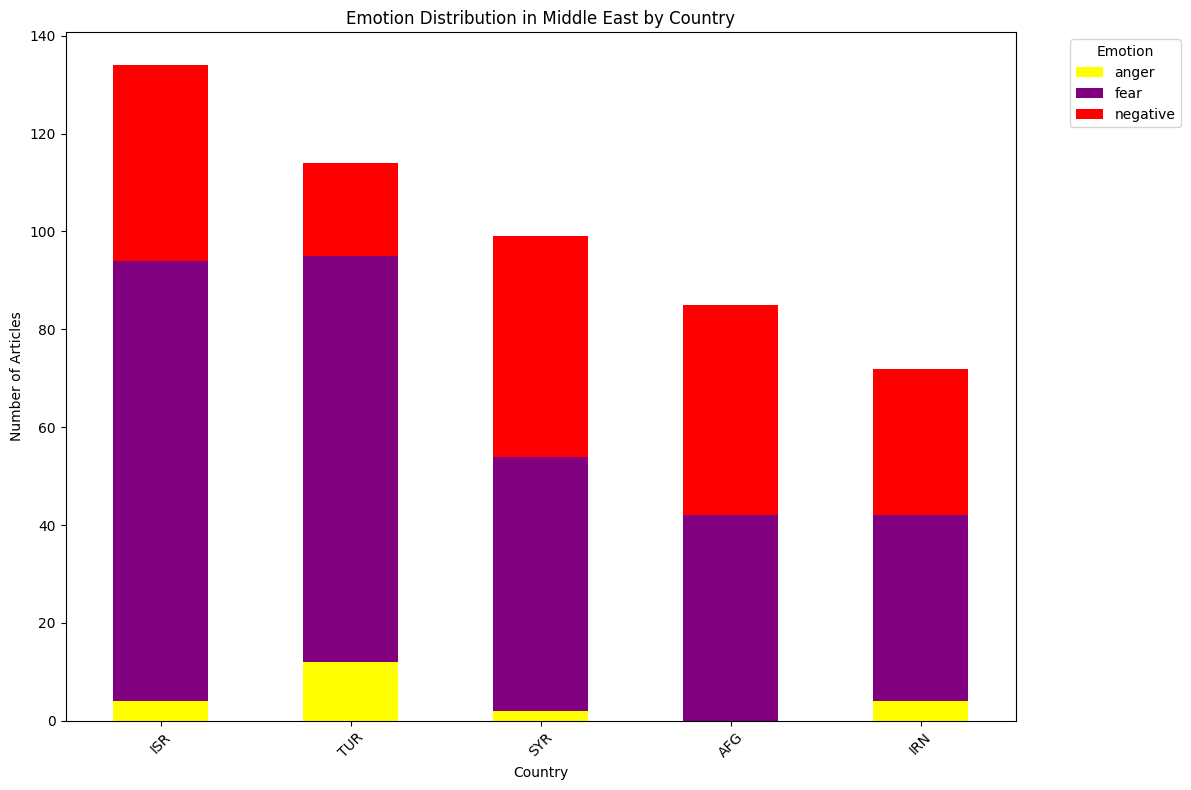

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed data
df = pd.read_csv('/content/drive/My Drive/Conflict_data/GDELT/middle_east_scraped_articles_clean_score.csv')

# Filter for the specific countries and emotions
filtered_df = df[(df['emotion'].isin(['anger', 'fear', 'negative'])) & (df['Actor1CountryCode'].isin(['ISR', 'TUR', 'IRN', 'AFG', 'SYR']))]

# Group by country and emotion, and count occurrences
country_emotion_count = filtered_df.groupby(['Actor1CountryCode', 'emotion']).size().unstack(fill_value=0)

# Calculate the total count for sorting
country_emotion_count['total'] = country_emotion_count.sum(axis=1)

# Sort the data by total count in descending order
country_emotion_count = country_emotion_count.sort_values(by='total', ascending=False).drop(columns='total')

# Plotting the data
plt.figure(figsize=(12, 8))
country_emotion_count.plot(kind='bar', stacked=True, color=['yellow', 'purple', 'red'], ax=plt.gca())
plt.title('Emotion Distribution in Middle East by Country')
plt.xlabel('Country')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## NER (Named Entity Recognition) Process
---

In [ ]:
!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 3.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

In [ ]:
import pandas as pd
import spacy

# Load SpaCy's English language model
nlp = spacy.load('en_core_web_trf')

# Load the processed data
df = pd.read_csv('/content/drive/My Drive/Conflict_data/GDELT/middle_east_scraped_articles_clean_score.csv')

# Filter for specific emotions
filtered_df = df[df['emotion'].isin(['anger', 'fear', 'negative', 'disgust'])]

# Function to extract named entities from text
def extract_entities(text):
    if isinstance(text, str):  # Check if the input is a string
        doc = nlp(text)
        entities = [(entity.text, entity.label_) for entity in doc.ents]
        return entities
    else:
        return []  # Return an empty list if the input is not a string

# Apply NER to the processed_content column
filtered_df['entities'] = filtered_df['processed_content'].apply(extract_entities)

# Save the results
filtered_df.to_csv('/content/drive/My Drive/Conflict_data/GDELT/middle_east_scraped_articles_clean_score_ner_trf_model.csv', index=False)

# Display a few rows to verify
print(filtered_df[['processed_content', 'entities']].head())

<ipython-input-1-a1787a013897>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['entities'] = filtered_df['processed_content'].apply(extract_entities)


                                    processed_content  \
1   blast went central residential area city explo...   
4   wasnt deadliest year syria ongoing civil war p...   
9   por europa press enero el clérigo opositor sau...   
10  murderous isi terrorist carried horrific publi...   
12  fisher institute air space strategic study pub...   

                                             entities  
1   [(afghan, NORP), (three, CARDINAL), (taliban, ...  
4   [(year, DATE), (syria, GPE), (fifth year, DATE...  
9   [(europa press, ORG), (enero, DATE), (el cléri...  
10  [(isi, NORP), (daily star, WORK_OF_ART), (wtf ...  
12  [(fisher institute, ORG), (monday, DATE), (rus...  


Most common entities:
[('iraq', 752), ('iran', 685), ('israeli', 616), ('palestinian', 562), ('israel', 507), ('syria', 326), ('afghanistan', 316), ('iranian', 290), ('taliban', 276), ('pakistan', 260)]
Top 50 common entities (filtered):
iraq: 752
iran: 685
israeli: 616
palestinian: 562
israel: 507
syria: 326
afghanistan: 316
iranian: 290
taliban: 276
pakistan: 260
turkish: 250
iraqi: 248
afghan: 210
syrian: 210
turkey: 210
saudi: 208
erbil: 203
kurdistan: 165
islamic: 153
yemen: 150
mogadishu: 150
american: 149
hezbollah: 141
trump: 126
kurdish: 122
gaza: 122
gaza strip: 117
somalia: 115
lebanon: 99
arab: 97
kabul: 92
baghdad: 91
jerusalem: 90
united state: 85
egypt: 81
houthis: 80
russian: 78
islamic state: 71
donald trump: 69
hamas: 69
india: 67
middle east: 67
daesh: 66
russia: 64
alaqsa mosque: 64
kataib: 63
muslim: 59
shia: 58
second: 55
mosul: 55


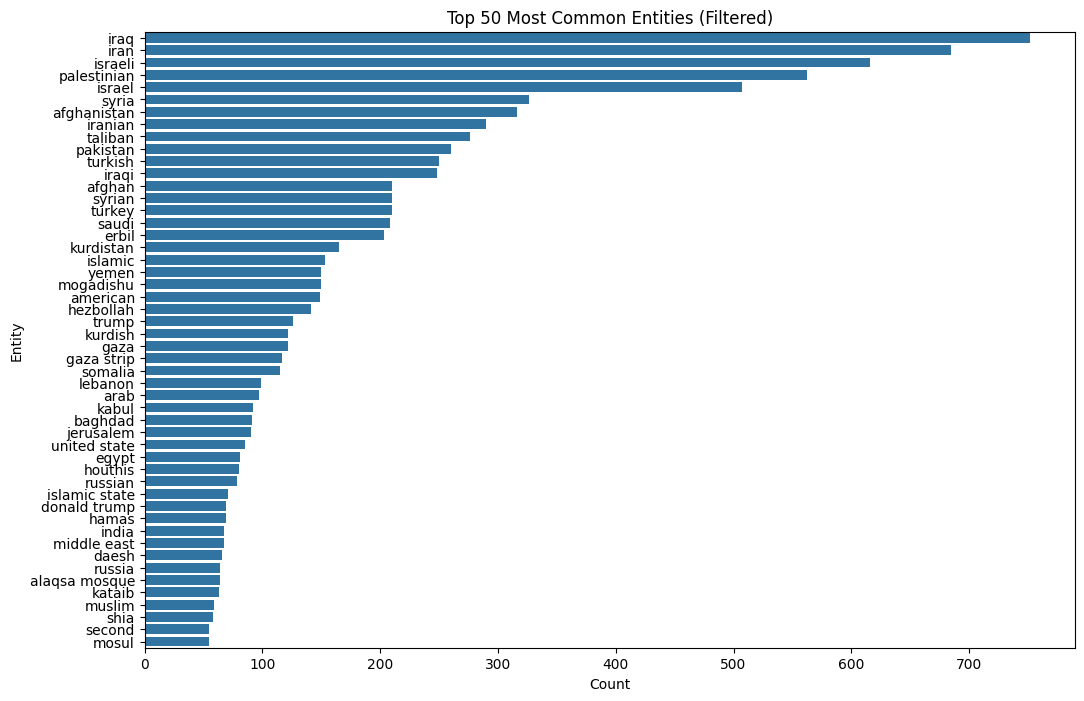

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load the processed data with entities
df = pd.read_csv('/content/drive/My Drive/Conflict_data/GDELT/middle_east_scraped_articles_clean_score_ner_trf_model.csv')

# Convert the string representation of entities back to tuples
df['entities'] = df['entities'].apply(eval)

# Extract entities and labels
entities = [entity for sublist in df['entities'] for entity in sublist]
entity_texts = [entity[0].lower() for entity in entities if entity[0].lower() not in {'fha','fha home', 'fha washington', 'home loans', 'virginia fha',
                  'florida fha', 'wisconsin fha', 'de la', 'west virginia', 'home', 'loans','said', 'de', 'wisconsin home', 'washington home', 'virginia',
                  'west', 'florida', 'washington', 'u', 'U', 'la', 'wisconsin', 'wyoming', 'two', 'one', 'un', 'first', 'four', 'three', 'june', 'september',
                  'november', 'six', 'five', 'december', 'nine', 'wednesday', 'sunday', 'saturday', 'march', 'april', 'may', 'january', 'february', 'friday',
                  'last week', 'day', 'year', 'isi', 'july', 'million', 'july', 'today', 'week', 'thousand', 'thursday', 'monday', 'tuesday', 'hundred', 'month',
                  'october', 'arabia', 'last year', 'alaqsa', 'interior ministry'}]

entity_labels = [entity[1] for entity in entities]

# Count the frequency of each entity and entity type
entity_counts = Counter(entity_texts)
label_counts = Counter(entity_labels)

# Display the most common entities
print("Most common entities:")
print(entity_counts.most_common(10))

# Display the most common entities
top_entities = entity_counts.most_common(50)
print("Top 50 common entities (filtered):")
for entity, count in top_entities:
    print(f"{entity}: {count}")

# Visualize the most common entities
common_entities_df = pd.DataFrame(top_entities, columns=['Entity', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Entity', data=common_entities_df)
plt.title('Top 50 Most Common Entities (Filtered)')
plt.xlabel('Count')
plt.ylabel('Entity')
plt.show()

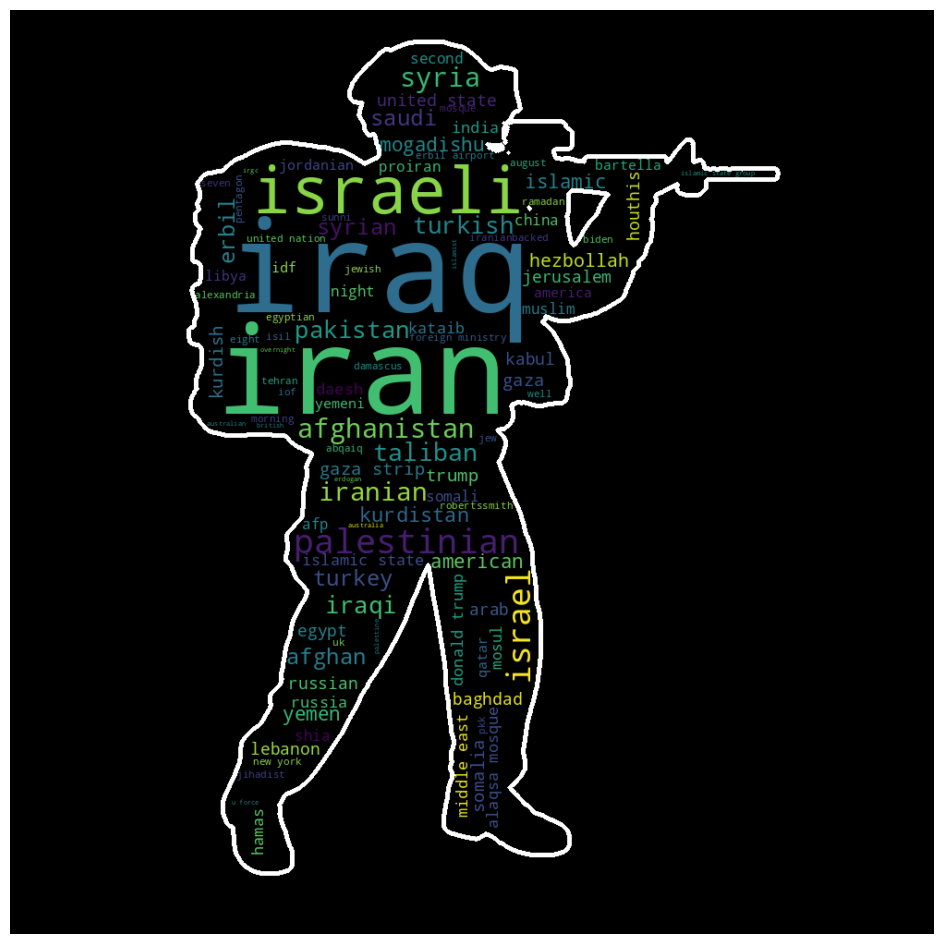

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter

# Load the processed data
df = pd.read_csv('/content/drive/My Drive/Conflict_data/GDELT/middle_east_scraped_articles_clean_score_ner_trf_model.csv')

# Define the exclusion list
exclude_list = {'fha','fha home', 'fha washington', 'home loans', 'virginia fha',
                  'florida fha', 'wisconsin fha', 'de la', 'west virginia', 'home', 'loans','said', 'de', 'wisconsin home', 'washington home', 'virginia',
                  'west', 'florida', 'washington', 'u', 'U', 'la', 'wisconsin', 'wyoming', 'two', 'one', 'un', 'first', 'four', 'three', 'june', 'september',
                  'november', 'six', 'five', 'december', 'nine', 'wednesday', 'sunday', 'saturday', 'march', 'april', 'may', 'january', 'february', 'friday',
                  'last week', 'day', 'year', 'isi', 'july', 'million', 'july', 'today', 'week', 'thousand', 'thursday', 'monday', 'tuesday', 'hundred', 'month',
                  'october', 'arabia', 'last year', 'alaqsa', 'interior ministry' }

# Extract entities and flatten the list
entities = df['entities'].apply(lambda x: eval(x) if pd.notnull(x) else []).explode().dropna()

# Filter out unwanted terms and count frequencies
filtered_entities = [entity for entity, label in entities if entity.lower() not in exclude_list]
entity_counter = Counter(filtered_entities)

# Get the top 100 entities
top_entities = entity_counter.most_common(100)

# Load the mask image
mask_path = '/content/drive/My Drive/Conflict_data/Word_Cloud_Images/PNG_Files/soldier_silhouette_v2.png'
mask = np.array(Image.open(mask_path))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='black', mask=mask,
                      contour_width=5, contour_color='white').generate_from_frequencies(dict(top_entities))

# Display the word cloud
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
import pandas as pd
import spacy
from collections import Counter
from itertools import chain

# Load SpaCy's English language model
nlp = spacy.load('en_core_web_trf')

# Load the processed data
df = pd.read_csv('/content/drive/My Drive/Conflict_data/GDELT/middle_east_scraped_articles_clean_score_ner_trf_model.csv')

# Keywords to filter
keywords = ['daesh', 'kataib']

# Function to extract entities from sentences containing specific keywords
def extract_co_occurring_entities(text, keywords):
    if isinstance(text, str):
        doc = nlp(text)
        sentences = [sent.text for sent in doc.sents if any(keyword in sent.text.lower() for keyword in keywords)]
        co_entities = []
        for sentence in sentences:
            sentence_doc = nlp(sentence)
            entities = [(entity.text, entity.label_) for entity in sentence_doc.ents]
            co_entities.extend(entities)
        return co_entities
    else:
        return []

# Extract co-occurring entities
df['co_entities'] = df['processed_content'].apply(lambda x: extract_co_occurring_entities(x, keywords))

# Flatten the list of entities and count occurrences
all_co_entities = list(chain(*df['co_entities'].tolist()))
co_entity_counts = Counter(all_co_entities)

# Display the most common co-occurring entities
common_co_entities = co_entity_counts.most_common(30)
print("Most common entities occurring with 'daesh' and 'kataib':")
for entity, count in common_co_entities:
    print(f"{entity[0]} ({entity[1]}): {count}")

Most common entities occurring with 'daesh' and 'kataib':
iraq (GPE): 240
iran (GPE): 203
erbil (GPE): 153
kurdistan (GPE): 108
turkish (NORP): 103
iranian (NORP): 70
turkey (GPE): 55
houthis (NORP): 50
one (CARDINAL): 48
september (DATE): 48
daesh (GPE): 43
syria (GPE): 41
isi (NORP): 37
kataib (PERSON): 35
kurdish (NORP): 34
hezbollah (GPE): 34
iraqi (NORP): 33
arabia (GPE): 31
erbil airport (FAC): 31
saudi (GPE): 30
iran (NORP): 30
israeli (NORP): 29
yemen (GPE): 29
iranianbacked (NORP): 28
six (CARDINAL): 27
bartella (GPE): 27
abqaiq (GPE): 27
iraqthe (GPE): 26
wariran (GPE): 26
bashiqa (GPE): 25


<ipython-input-1-1519ae26d5c2>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['entities'] = filtered_df['processed_content'].apply(extract_entities)


Top 20 entities related to 'Daesh' and 'Kataib':
erbil: 176
turkish: 136
iranian: 127
kurdistan: 127
turkey: 86
iraqi: 66
hezbollah: 54
kurdish: 49
syria: 48
bartella: 44
houthis: 39
proiran: 35
saudi: 34
israeli: 31
iranianbacked: 30
abqaiq: 30
yemen: 30
shayban: 30
bashiqa: 29
wariran: 29


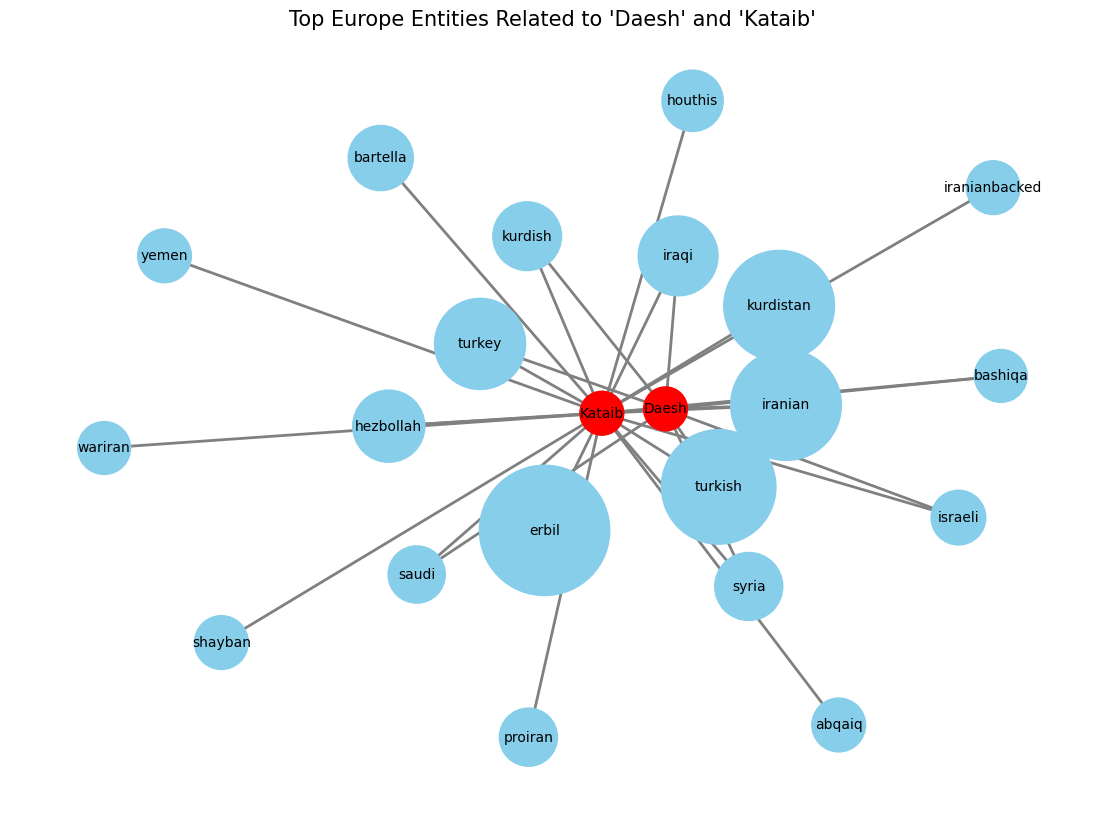

In [ ]:
import pandas as pd
import spacy
import networkx as nx
import matplotlib.pyplot as plt

# Load SpaCy's English language model
nlp = spacy.load('en_core_web_trf')

# Load the processed data
df = pd.read_csv('/content/drive/My Drive/Conflict_data/GDELT/middle_east_scraped_articles_clean_score_ner_trf_model.csv')

# Filter for specific emotions
filtered_df = df[df['emotion'].isin(['anger', 'fear', 'negative'])]

# Function to extract named entities from text
def extract_entities(text):
    if not isinstance(text, str):
        return []  # Return an empty list if the text is not a string
    doc = nlp(text)
    entities = [(entity.text, entity.label_) for entity in doc.ents]
    return entities

# Apply NER to the processed_content column
filtered_df['entities'] = filtered_df['processed_content'].apply(extract_entities)

# Extract entities related to "daesh" and "kataib"
main_entities = ["daesh", "kataib"]
related_entities = {entity: [] for entity in main_entities}

for entities in filtered_df['entities']:
    for main_entity in main_entities:
        if any(main_entity in entity[0].lower() for entity in entities):
            related_entities[main_entity].extend([entity for entity in entities if entity[0].lower() != main_entity])

# Count frequency of each entity
entity_counts = {}
for main_entity, entities in related_entities.items():
    for entity in entities:
        entity_counts[entity[0]] = entity_counts.get(entity[0], 0) + 1

# Remove irrelevant entities
irrelevant_entities = {'fha','fha home', 'fha washington', 'home loans', 'virginia fha',
                  'florida fha', 'wisconsin fha', 'de la', 'west virginia', 'home', 'loans','said', 'de', 'wisconsin home', 'washington home', 'virginia',
                  'west', 'florida', 'washington', 'u', 'U', 'la', 'wisconsin', 'wyoming', 'two', 'one', 'un', 'first', 'four', 'three', 'june', 'september',
                  'november', 'six', 'five', 'december', 'nine', 'wednesday', 'sunday', 'saturday', 'march', 'april', 'may', 'january', 'february', 'friday',
                  'last week', 'day', 'year', 'isi', 'july', 'million', 'july', 'today', 'week', 'thousand', 'thursday', 'monday', 'tuesday', 'hundred', 'month',
                  'october', 'arabia', 'last year', 'alaqsa', 'interior ministry', 'daesh', 'kataib', 'erbil airport','iran', 'iraq', 'iraqhowever', 'iraqthe', 'israel'}
entity_counts = {entity: count for entity, count in entity_counts.items() if entity.lower() not in irrelevant_entities}

# Sort entities by frequency and select the top 20
sorted_entities = sorted(entity_counts.items(), key=lambda item: item[1], reverse=True)[:20]

# Print the top 20 entities
print("Top 20 entities related to 'Daesh' and 'Kataib':")
for entity, count in sorted_entities:
    print(f"{entity}: {count}")

# Create a graph
G = nx.Graph()

# Add nodes and edges for main entities and top related entities
for main_entity in main_entities:
    G.add_node(main_entity.capitalize(), size=1000, color='red')

for entity, count in sorted_entities:
    G.add_node(entity, size=count * 50, color='skyblue')
    for main_entity in main_entities:
        if entity in [ent[0] for ent in related_entities[main_entity]]:
            G.add_edge(main_entity.capitalize(), entity, weight=count)

# Extract node attributes for drawing
node_sizes = [G.nodes[node]['size'] for node in G.nodes]
node_colors = [G.nodes[node]['color'] for node in G.nodes]

# Draw the graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5)
nx.draw_networkx(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=10, font_color='black', edge_color='gray', width=2, edge_cmap=plt.cm.Blues)
plt.title("Top Europe Entities Related to 'Daesh' and 'Kataib'", fontsize=15)
plt.axis('off')
plt.show()